In [189]:
import numpy as np
#numpy.set_printoptions(threshold=numpy.nan)
import argparse
import imutils
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 15]

Center of contour

In [190]:
def countourCenter(image, MIN_THRESH = 1):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(image_gray, (5, 5), 0)
    image_gray = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]
    cnts = cv2.findContours(image_gray.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    coor = [] 
    # loop over the contours
    for c in cnts:
        if cv2.contourArea(c) > MIN_THRESH:
            # compute the center of the contour
            M = cv2.moments(c)
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cXfloat = (M["m10"] / M["m00"])
            cYfloat = (M["m01"] / M["m00"])
            coor.append([cXfloat,cYfloat])
            # draw the contour and center of the shape on the image
            cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
            cv2.circle(image, (cX, cY), 7, (255, 255, 255), -1)
            cv2.putText(image, "center", (cX - 20, cY - 20),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
            
    return image, coor, cnts

Goal: Output X and Y coordinate for each star

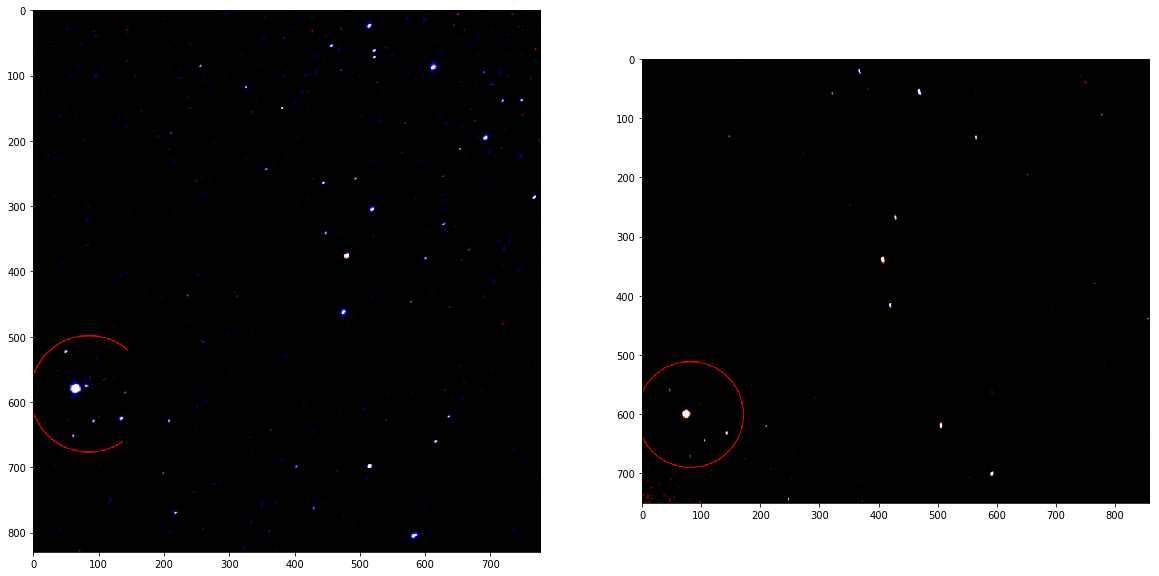

In [191]:
# load the image: 
pic1 = mpimg.imread('/Users/jeffhe/Desktop/commitments/bliss/Solar-sail-localization/picbase/Jupiter Picture1.jpg')
pic2 = mpimg.imread('/Users/jeffhe/Desktop/commitments/bliss/Solar-sail-localization/picbase/Jupiter Picture2.jpg')
plt.subplot(1,2,1), plt.imshow(pic1)
plt.subplot(1,2,2), plt.imshow(pic2)
pic1.setflags(write=1)
pic2.setflags(write=1)

(<matplotlib.axes._subplots.AxesSubplot at 0x12f1357b8>,
 <matplotlib.image.AxesImage at 0x132ba83c8>)

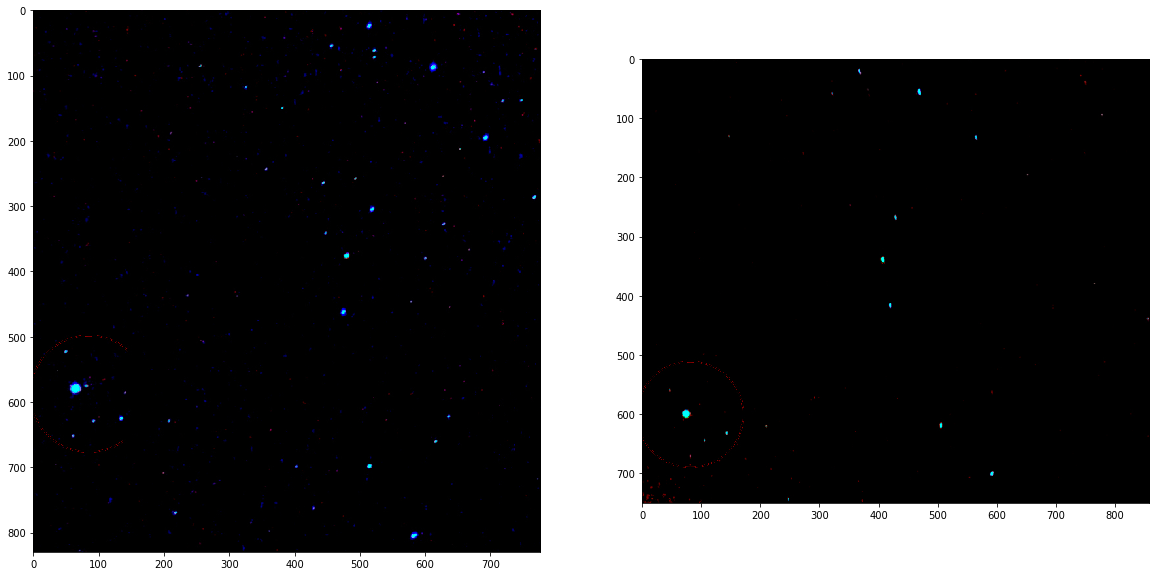

In [192]:
#eliminate the red part in both pictures 
for row in range(len(pic1)): 
    for col in range(len(pic1[row])): 
        if pic1[row,col,0] > 150: 
            pic1[row,col,0] = 0

for row in range(len(pic2)): 
    for col in range(len(pic2[row])): 
        if pic2[row,col,0] > 150: 
            pic2[row,col,0] = 0

plt.subplot(1,2,1), plt.imshow(pic1)
plt.subplot(1,2,2), plt.imshow(pic2)

(<matplotlib.axes._subplots.AxesSubplot at 0x13e08ee10>,
 <matplotlib.image.AxesImage at 0x13ee521d0>)

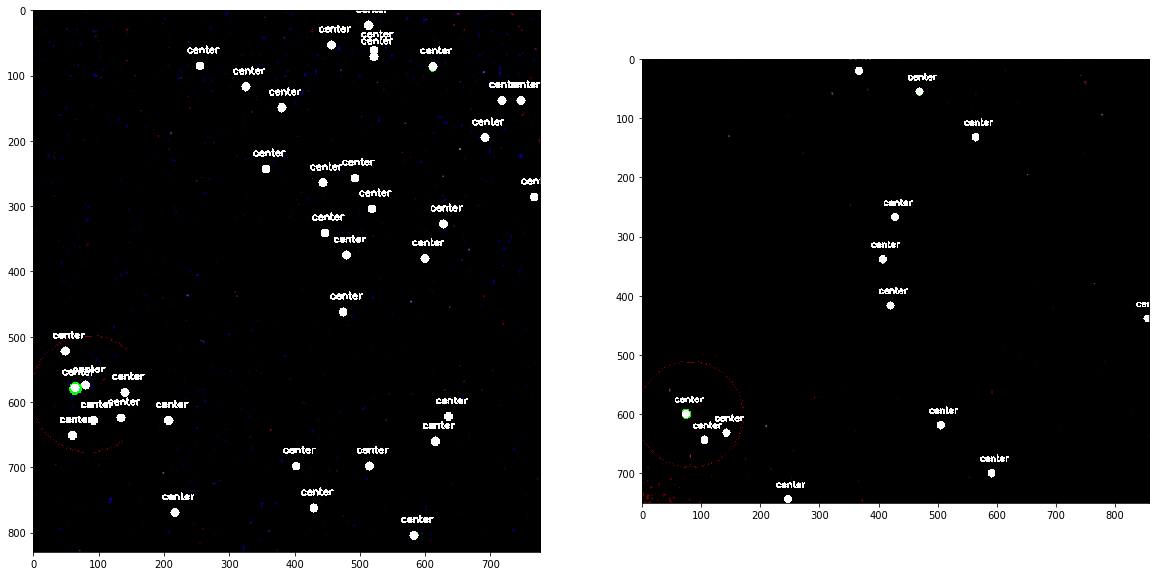

In [193]:
result1, coor1, cnts1 = countourCenter(pic1.copy(),MIN_THRESH = 1)
result2, coor2, cnts2 = countourCenter(pic2.copy(),MIN_THRESH = 1)
plt.subplot(1,2,1), plt.imshow(result1)
plt.subplot(1,2,2), plt.imshow(result2)

classify the stars according to brightness 

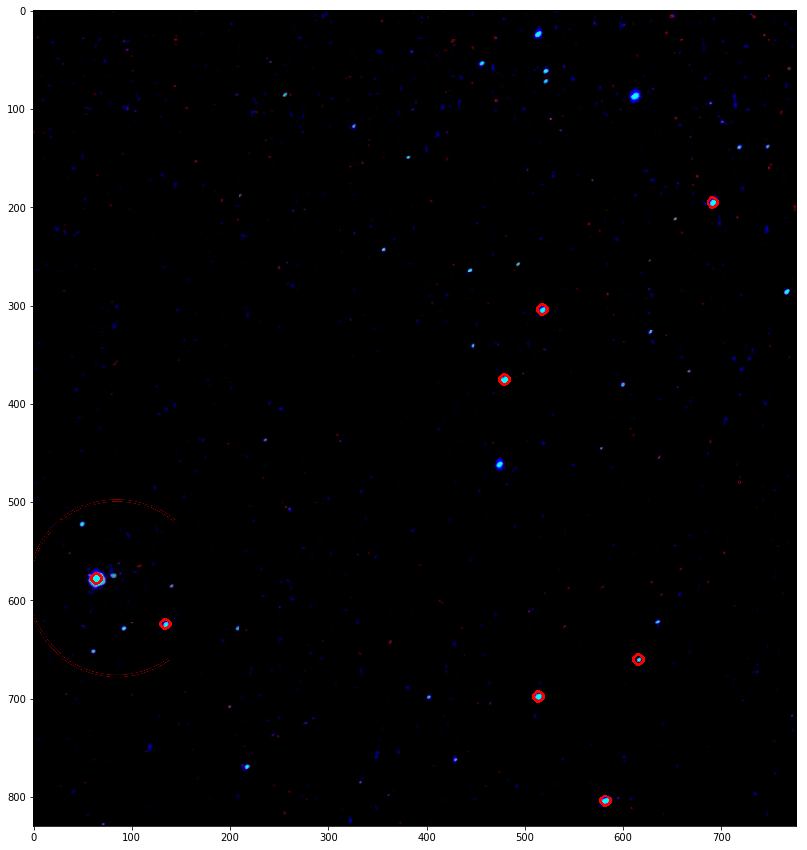

In [194]:
def arrayOfBrightest(image, topN, cnts, coor, MIN_THRESH = 1): 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    means = [] 
    topNArray = [] 
    for contour in cnts:
        if cv2.contourArea(contour) > MIN_THRESH:
            mean, stddev = getContourStat(contour, gray) 
            means.append(mean[0][0]) 
    count = 0 
    while count < topN: 
        index = means.index(max(means))
        topNArray.append(index) 
        means[index] = -1
        count += 1 
    count = 0 
    while count < topN: 
        topNArray[count] = coor[topNArray[count]] 
        count += 1 
    return topNArray
        


def getContourStat(contour,image):
    mask = np.zeros(image.shape,dtype="uint8")
    cv2.drawContours(mask, [contour], -1, 255, -1)
    mean,stddev = cv2.meanStdDev(image,mask=mask) 
    return mean, stddev


def drawCircles(topNArray,img):
    for i in topNArray: 
        cv2.circle(img, (int(i[0]),int(i[1])), 5, (255,0,0), thickness=2)
    plt.imshow(img)

topNArray = arrayOfBrightest(pic1.copy(),8,cnts1,coor1)
drawCircles(topNArray,pic1.copy())


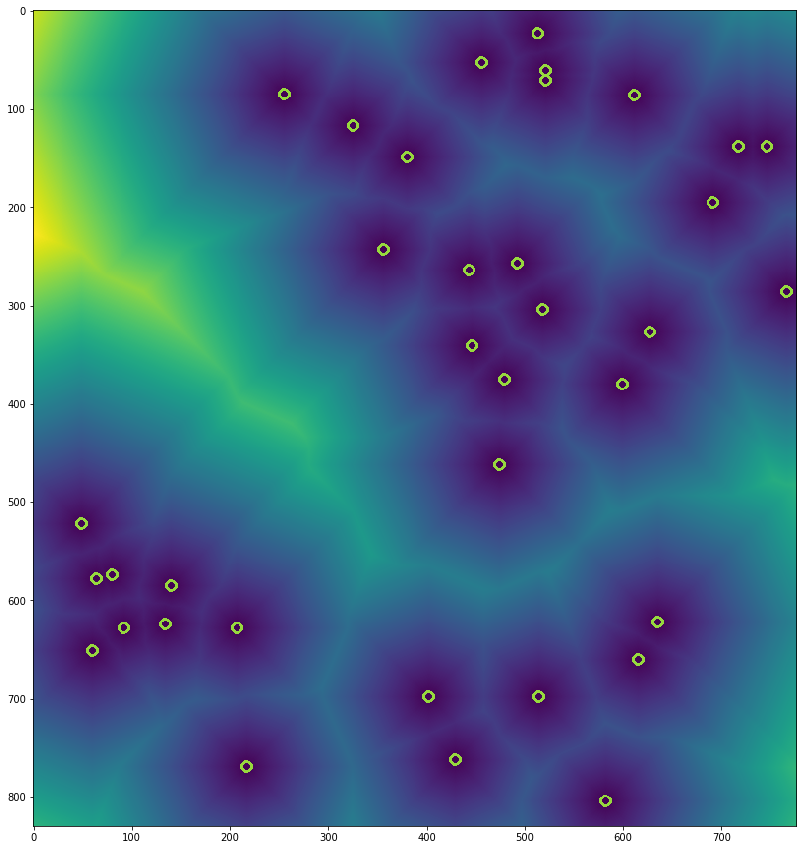

In [271]:
def distanceMap(image,coor): 
    copy = image.copy()
    gray = cv2.cvtColor(copy, cv2.COLOR_BGR2GRAY)
    distanceMap = np.zeros((copy.shape[0],copy.shape[1]), dtype=int)
    for i in coor: 
        distanceMap[int(i[1])][int(i[0])] = 1 
    distanceMap = 1 - distanceMap
    distanceMap = distanceMap.astype(np.uint8)
    distanceMap = cv2.distanceTransform(distanceMap, cv2.DIST_L2, 3)
    display = distanceMap.copy()
    for i in coor: 
        cv2.circle(display, (int(i[0]),int(i[1])), 5, (255,0,0), thickness=2)
        plt.imshow(display)
    return distanceMap 

distanceMap = distanceMap(pic1,coor1)